In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nishimapanwar","key":"d1abe189d94031147a8882338cf08708"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-07-07 19:18:09           9249  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5666  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2054  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2406  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [7]:
!kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.80G/1.81G [00:14<00:00, 96.3MB/s]
100% 1.81G/1.81G [00:15<00:00, 121MB/s] 


In [8]:
!unzip 100-bird-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: birds_rev2/train/TOWNSENDS WARBLER/091.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/092.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/093.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/094.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/095.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/096.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/097.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/098.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/099.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/100.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/101.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/102.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/103.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/104.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/105.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/106.jpg  
  inflating: birds_re

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import time
import copy
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torchvision.transforms as transform

In [11]:
transform = transform.Compose([transform.RandomHorizontalFlip(),
                                transform.RandomRotation(0.2),
                                transform.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transform.Resize((80,80))
                               ])

In [10]:
if torch.cuda.is_available():
    dev = "cuda:0"  
else:
    dev = "cpu"
device = torch.device(dev)

In [12]:
train= torchvision.datasets.ImageFolder(root="/content/birds/train", transform=transform)
val= torchvision.datasets.ImageFolder(root="/content/birds/valid", transform=transform)
test= torchvision.datasets.ImageFolder(root="/content/birds/test", transform=transform)

In [13]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(val,batch_size=32,shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test,batch_size=32,shuffle=False)

dataloaders = {
    "train": train_data_loader,   
    "valid": valid_data_loader, 
    "test": test_data_loader
}
datasizes = {
    "train": len(train),
    "valid": len(val),
    "test": len(test)
}
CLASSES = list(train.class_to_idx.keys())

In [14]:

def imshow(img, size=(10, 10)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("One mini batch")
    plt.axis("off")
    plt.pause(0.001)

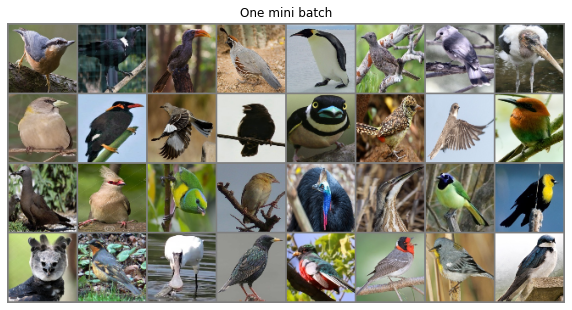

In [15]:
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [16]:
cuda = False
if torch.cuda.is_available():
    cuda = True

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(5*5*128, 1600)
        self.fc2 = nn.Linear(1600, 3200)
        self.fc3 = nn.Linear(3200, len(CLASSES))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [18]:
model = Net()
if cuda==True:
    model.cuda()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
model = Net().to(device)

In [22]:
train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 10

In [24]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [25]:
for epoch in range(epochs):
    
    start = time.time()
    
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1   
    
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    for images, labels in train_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        preds = model(images)
        
        acc = calc_accuracy(labels.cpu(), preds.cpu())
              
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
       loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
        if _iter % 500 == 0:
            print("> Iteration {} < ".format(_iter))
            print("Iter Loss = {}".format(round(loss_value, 4)))
            print("Iter Accuracy = {} % \n".format(acc))
        
        _iter += 1
    
   for images, labels in valid_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        preds = model(images)
        
        acc = calc_accuracy(labels.cpu(), preds.cpu())        
        
        loss = criterion(preds, labels)        
       
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))

> Iteration 500 < 
Iter Loss = 5.6238
Iter Accuracy = 0.0 % 

> Iteration 1000 < 
Iter Loss = 5.6289
Iter Accuracy = 0.0 % 

** Epoch 0 ** - Epoch Time 674
Train Loss = 5.6392
Train Accuracy = 0.487408610885459 % 

Val Loss = 5.6427
Val Accuracy = 0.3633720930232558 % 

> Iteration 500 < 
Iter Loss = 5.6422
Iter Accuracy = 6.25 % 

> Iteration 1000 < 
Iter Loss = 5.6344
Iter Accuracy = 0.0 % 

** Epoch 1 ** - Epoch Time 663
Train Loss = 5.6395
Train Accuracy = 0.4010966693744923 % 

Val Loss = 5.6446
Val Accuracy = 0.29069767441860467 % 

> Iteration 500 < 
Iter Loss = 5.6109
Iter Accuracy = 0.0 % 

> Iteration 1000 < 
Iter Loss = 5.677
Iter Accuracy = 3.125 % 

** Epoch 2 ** - Epoch Time 669
Train Loss = 5.6395
Train Accuracy = 0.45440698619008935 % 

Val Loss = 5.6416
Val Accuracy = 0.3633720930232558 % 

> Iteration 500 < 
Iter Loss = 5.5952
Iter Accuracy = 0.0 % 

> Iteration 1000 < 
Iter Loss = 5.681
Iter Accuracy = 0.0 % 

** Epoch 3 ** - Epoch Time 657
Train Loss = 5.6398
Train 

In [29]:
total_step = len(test_data_loader)
for epoch in range(epochs):
    model.eval()
    test_accuracy=0
    val_accuracy=0
    for i, (images, labels) in enumerate(test_data_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        preds = outputs.data.max(dim = 1, keepdim = True)[1]
        test_accuracy += preds.eq(labels.data.view_as(preds)).cpu().sum()
        
        
    test_accuracy = test_accuracy/len(test_data_loader.dataset) * 100
        
    print ('Epoch [{}/{}], Loss: {:.4f}, Testing Accuracy: {}' 
                   .format(epoch+1, epochs, loss.item(), test_accuracy))

Epoch [1/10], Loss: 5.5735, Testing Accuracy: 0.2181818187236786
Epoch [2/10], Loss: 5.5651, Testing Accuracy: 0.5090909004211426
Epoch [3/10], Loss: 5.5671, Testing Accuracy: 0.581818163394928
Epoch [4/10], Loss: 5.5463, Testing Accuracy: 0.3636363744735718
Epoch [5/10], Loss: 5.5938, Testing Accuracy: 0.5090909004211426
Epoch [6/10], Loss: 5.5815, Testing Accuracy: 0.4363636374473572
Epoch [7/10], Loss: 5.5781, Testing Accuracy: 0.5090909004211426
Epoch [8/10], Loss: 5.6133, Testing Accuracy: 0.290909081697464
Epoch [9/10], Loss: 5.5914, Testing Accuracy: 0.3636363744735718
Epoch [10/10], Loss: 5.5642, Testing Accuracy: 0.4363636374473572


In [30]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 8000 test images with Relu is: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 8000 test images with Relu is: 0.4775937404735291 %
